# Проект: A/B тестирование для интернет-магазина

## Описание проекта

**Контекст**<br>
Отдел маркетинга подготовил список гипотез для увеличения выручки интернет-магазина.<br>
В части 1 нужно приоритизировать гипотезы. В части 2 - проанализировать результаты A/B-теста. 

**Входные данные**<br>
В файле `hypothesis.csv` 9 гипотез по увеличению выручки интернет-магазина.<br>
В файлах `orders.csv` и `visitors.csv` описаны результаты проведенного A/B-тестирования.

## Часть 1. Приоритизация гипотез

In [1]:
import pandas as pd

In [2]:
try:
    hypothesis = pd.read_csv('hypothesis.csv')
except:
    hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
    
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


**Описание данных:**<br>
`Hypothesis` - гипотеза;<br>
`Reach` - скольких пользователей затронет изменение, которое хотим внести; <br>
`Impact` - насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта; <br>
`Confidence` - насколько мы уверены, что это изменение повлияет на пользователей именно так; <br>
`Efforts` - сколько стоит протестировать эту гипотезу.

### ICE

$$ \text{ICE} = \frac{\text{Impact} \times \text{Confidence}}{\text{Effort}}$$

In [3]:
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis[['Hypothesis', 'ICE']].sort_values(by=['ICE'], ascending=False).style.format({'ICE': '{:.2f}'})

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


### RICE

$$ \text{ICE} = \frac{\text{Reach} \times \text{Impact} \times \text{Confidence}}{\text{Effort}}$$

In [4]:
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis[['Hypothesis', 'RICE']].sort_values(by=['RICE'], ascending=False).style.format({'RICE': '{:.2f}'})

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


### Вывод
Приоритеты при использовании ICE:<br>
- №9. Запустить акцию, дающую скидку на товар в день рождения (16.20)
- №1. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	(13.33)
- №8. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (11.20)
- №7. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию (8.00)
- №3. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа (7.00)

Пр№иоритеты при использовании RICE:<br>
- №8. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (112.00)
- №3. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа (56.00)
- №1. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (40.00)
- №7. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию (40.00)

При использовании фреймворка ICE не учитывается охват пользователей, поэтому гипотеза "Запустить акцию, дающую скидку на товар в день рождения" не оказалась приоритетной при использовании RICE, так как эта акция охватывает достаточно узкую аудиторию пользователей (Reach=1). 

Несмотря на то, что данные методы очень похожи, приоритезация гипотезы в зависимости от фреймворка, может существенно отличаться, если мы ищем гипотезу, которая охватит больший круг пользователей, то выбираем RICE, если этот компонент не так важен, то ICE.

В нашем случае, для проведения A/B теста выберем гипотезу №8 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

## Часть 2. Анализ A/B-теста

In [5]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

Загрузим и изучим данные.

In [6]:
try:
    orders = pd.read_csv('orders.csv')
    visitors = pd.read_csv('visitors.csv')
except:
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

In [7]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [8]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

**Описание данных:**<br>
`transactionId` — идентификатор заказа;<br>
`visitorId` — идентификатор пользователя, совершившего заказ; <br>
`date` — дата заказа;<br>
`revenue` — выручка заказа;<br>
`group` — группа A/B-теста (A или B).

In [9]:
visitors.info()
visitors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [10]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

**Описание данных:**<br>
`date` — дата;<br>
`group` — группа A/B-теста (A или B);<br>
`visitors` — количество посетителей интернет-магазина в указанной группе A/B-теста в указанную дату.<br> 

In [11]:
print(orders.duplicated().sum())
print(visitors.duplicated().sum())

0
0


Найдем пользователей, которые попали в обе группы.

In [12]:
bad_list = []
for user in orders['visitorId'].unique():
    users_orders = orders[orders['visitorId'] == user]
    if users_orders['group'].nunique() == 2:
        bad_list.append(users_orders['visitorId'].max())
print(f'{len(bad_list)} клиентов попало в разные группы')

58 клиентов попало в разные группы


In [13]:
for_drop = len(bad_list)/orders['visitorId'].nunique()
print(f'{for_drop:.2%}')

5.63%


In [14]:
orders = orders[~orders['visitorId'].isin(bad_list)]

### 1. Построим график кумулятивной выручки по группам

In [15]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date', 'group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = (datesGroups.apply(lambda x: orders[(orders['date'] <= x ['date']) & (orders['group'] == x ['group'])]
                    .agg({'date': 'max', 'group': 'max', 'transactionId': 'nunique', 'visitorId': 'nunique', 'revenue': 'sum'})
                    , axis=1))
ordersAggregated = ordersAggregated.sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = (datesGroups.apply(lambda x: visitors[(visitors['date'] <= x ['date']) & (visitors['group'] == x ['group'])]
                     .agg({'date': 'max', 'group': 'max', 'visitors': 'sum'})
                     , axis=1))
visitorsAggregated = visitorsAggregated.sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = pd.merge(ordersAggregated, visitorsAggregated, on=['date','group'], how='inner')
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


**Описание данных:**<br>
`date` — дата;<br>
`group` — группа A/B-теста (A или B);<br>
`orders` — кумулятивное количество заказов на указанную дату в указанной группе;<br>
`buyers` — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;<br>
`revenue` — кумулятивная выручка на указанную дату в указанной группе (средний чек);<br>
`visitors` — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.<br>

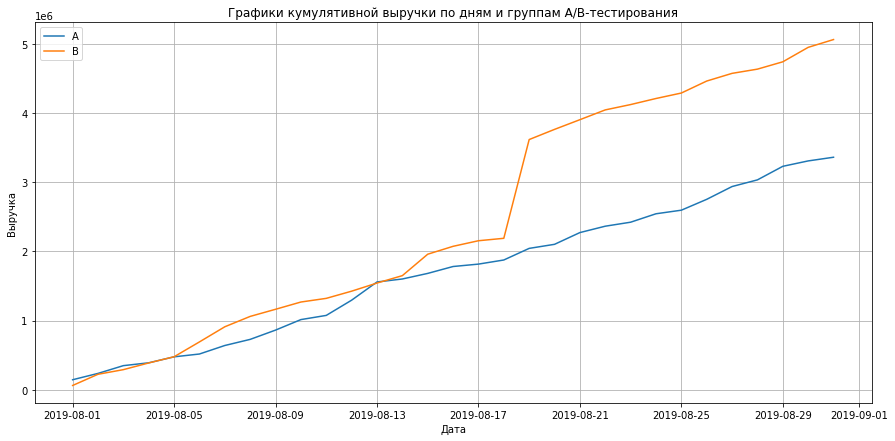

In [16]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(15,7))
plt.title('Графики кумулятивной выручки по дням и группам A/B-тестирования')

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xlabel('Дата')
plt.ylabel('Выручка') 
plt.grid()
plt.legend();

Выручка почти равномерно увеличивается в течение всего теста.

Сегмент B лидировал на протяжении всего теста. Однако график выручки группы В имеет точку резкого роста 19 августа 2019. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

### 2. Построим график кумулятивного среднего чека по группам

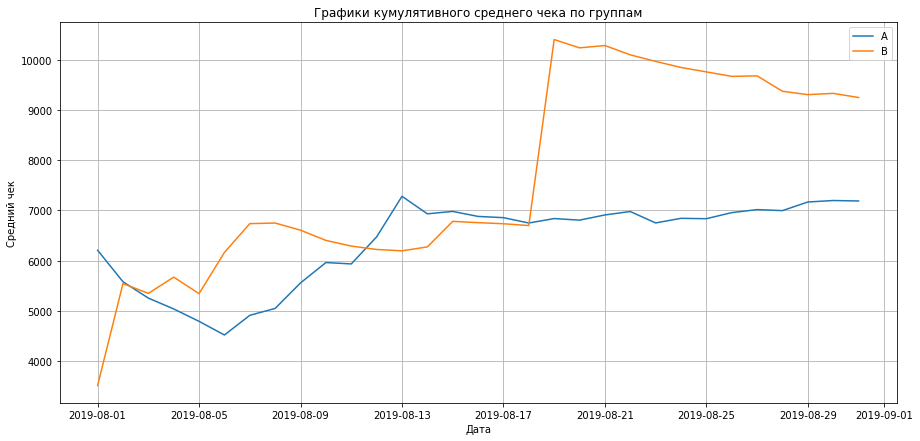

In [17]:
plt.figure(figsize=(15,7))
plt.title('Графики кумулятивного среднего чека по группам')

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'], label='B')

plt.xlabel('Дата')
plt.ylabel('Средний чек') 
plt.grid()
plt.legend();

В первой половине теста средний чек ведет себя нестабильно.

На графике среднего чека для группы B опять же присутствует скачок 19 августа 2019, очевидно, что в группу B попали крупные заказы, которые искажают поведение средних пользователей.

Средний чек становится более равномерным ближе к концу теста: установился для группы A и продолжает падать для группы B.

К концу теста коммулятивный средний чек группы B, выше, чем у А, но стоит учесть, что были аномальные значения.

### 3. Построим график относительного изменения кумулятивного среднего чека группы B к группе A

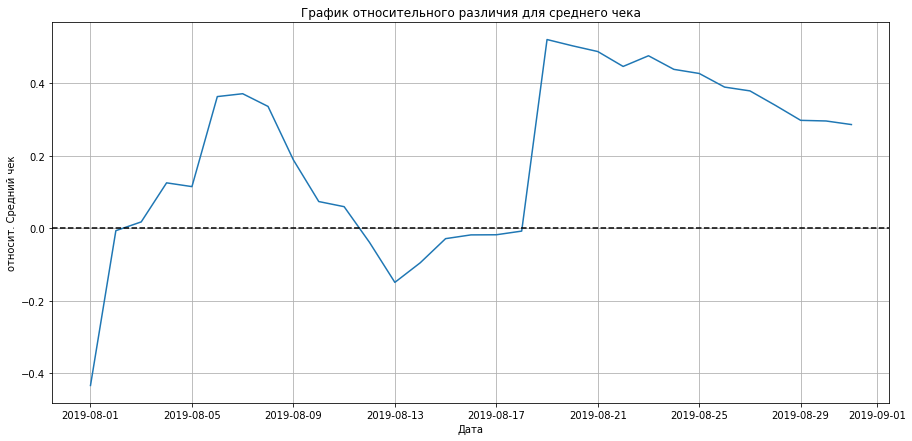

In [18]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = pd.merge(cumulativeRevenueA, cumulativeRevenueB, on=['date'], how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15,7))
plt.title('График относительного различия для среднего чека')

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB'] / mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA'] / mergedCumulativeRevenue['ordersA']) - 1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.xlabel('Дата')
plt.ylabel('относит. Средний чек') 
plt.grid();

В нескольких датах график различия между сегментами резко "скачет". Видимо именно тогда были совершенны аномальные заказы.

### 4. Построим график кумулятивного среднего количества заказов на посетителя по группам

Среднее количество заказов на посетителя то же самое, что конверсия.<br>
конверсия = кол-во заказов / кол-во посетителей = среднее количество заказов на посетителя

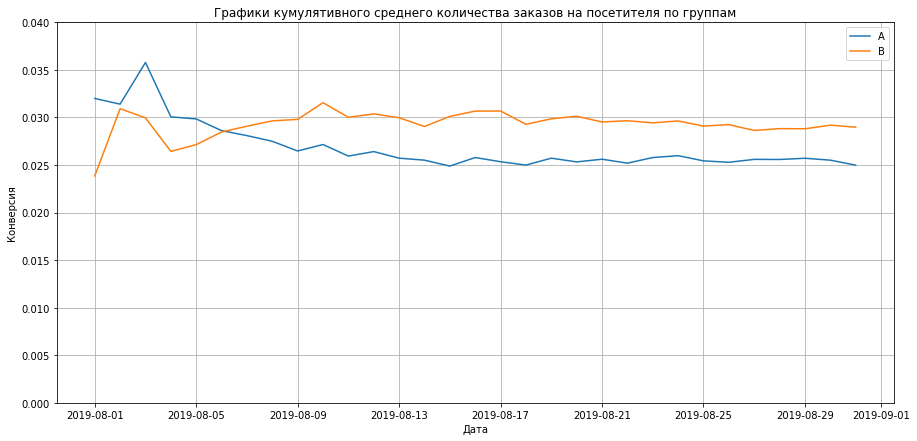

In [19]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

plt.figure(figsize=(15,7))
plt.title('Графики кумулятивного среднего количества заказов на посетителя по группам')

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.ylim(0, 0.04) 
plt.xlabel('Дата')
plt.ylabel('Конверсия') 
plt.grid()
plt.legend();

Конверсии обеих групп колебались в начале теста, и выровнялись уже во второй половине. К концу рассматриваемого периода конверсия группы В больше конверсии группы А.

### 5. Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

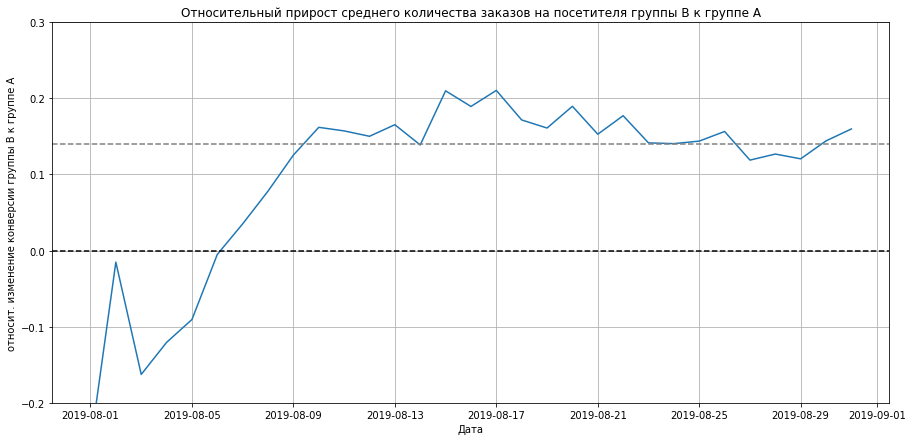

In [20]:
mergedCumulativeConversions = pd.merge(cumulativeDataA[['date','conversion']], cumulativeDataB[['date','conversion']], 
                                       on=['date'], how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15,7))
plt.title('Относительный прирост среднего количества заказов на посетителя группы B к группе A')

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB'] / 
         mergedCumulativeConversions['conversionA'] - 1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.14, color='grey', linestyle='--')

plt.xlabel('Дата')
plt.ylabel('относит. изменение конверсии группы В к группе А') 
plt.ylim(-0.2, 0.3)
plt.grid();

В начале теста группа B значительно проигрывала группе A, затем, уже начиная с 6 августа, конверсия группы группы B стабильно больше. Разница достигает максимального значения примерно в середине теста около 21%. Далее отношение немного падает и находится в пределах 10% - 15%.

В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. 

### 6. Построим точечный график количества заказов по пользователям

In [21]:
ordersByUsers = (orders.groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'}))
ordersByUsers.columns = ['userId', 'orders']
ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,userId,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


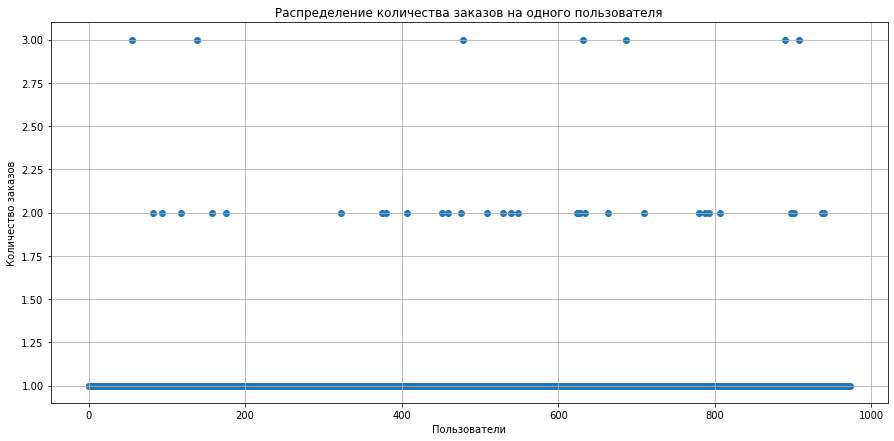

In [22]:
plt.figure(figsize=(15,7))
plt.title('Распределение количества заказов на одного пользователя')

x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов') 
plt.grid();

Много пользователей с 1 заказом. Пока их точная доля не ясна — непонятно, считать остальные аномалиями или нет.

### 7. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя и выберем границу для определения аномальных пользователей

In [23]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

Не более 1% пользователей оформляли больше чем 2 заказа. И не более 5% пользователей оформляли больше чем 1 заказа. 

Выберем 2 заказа на одного пользователя за верхнюю границу числа заказов, и потом отсеим аномальных пользователей по ней.

In [24]:
x = stats.percentileofscore(ordersByUsers['orders'], 2)
print(f'Таким образом, отбросим {100 - x:.2f}% данных.')

Таким образом, отбросим 2.16% данных.


### 8. Построим точечный график стоимостей заказов

In [25]:
revenueByOrders = orders[['visitorId', 'revenue']]
revenueByOrders.columns = ['orderId', 'revenue']
revenueByOrders.sort_values(by='revenue', ascending=False).head(10)

,orderId,revenue
425,1920142716,1294500
1196,2108080724,202740
1136,1307669133,92550
744,888512513,86620
743,4133034833,67990
1103,1164614297,66350
1099,148427295,65710
949,887908475,60450
940,4003628586,58550
131,2254586615,53904


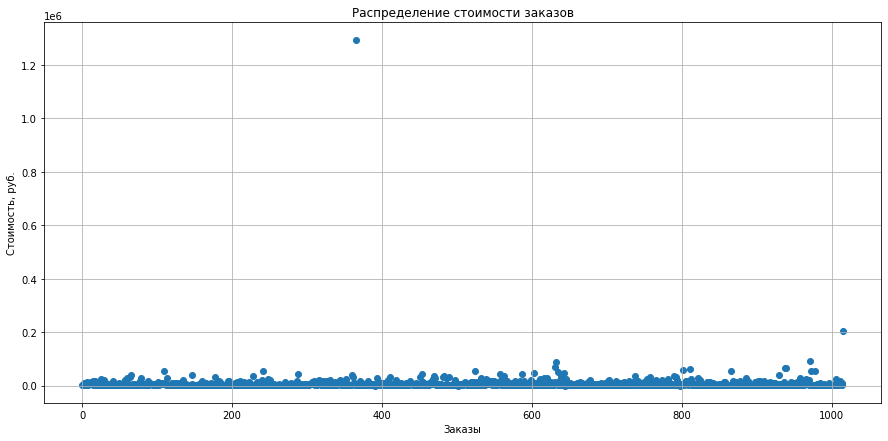

In [26]:
plt.figure(figsize=(15,7))
plt.title('Распределение стоимости заказов')

x_values = pd.Series(range(0,len(revenueByOrders)))

plt.scatter(x_values, revenueByOrders['revenue'])
plt.xlabel('Заказы')
plt.ylabel('Стоимость, руб.') 
plt.grid();

Самые очевидные выбросы на графике - это заказ стоимостью более 1 200 000 руб. и заказ стоимостью 200 000 руб.. 

Изменим масштаб, чтобы детальнее посмотреть на наиболее частые суммы заказов.

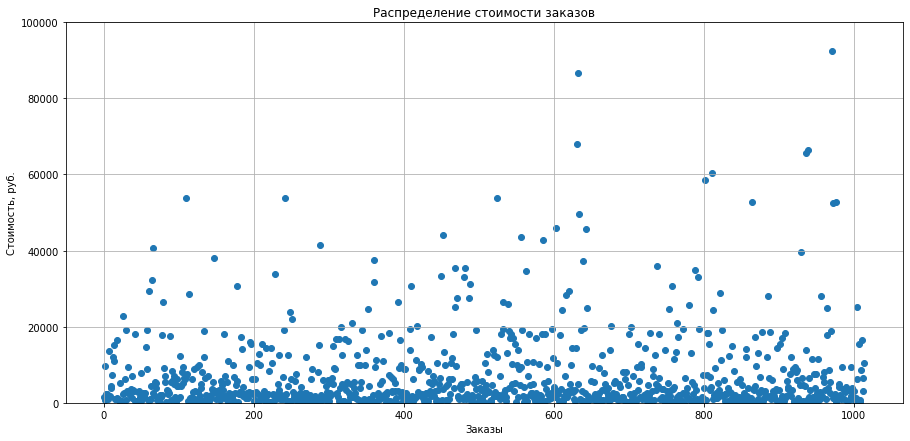

In [27]:
plt.figure(figsize=(15,7))
plt.title('Распределение стоимости заказов')
plt.scatter(x_values, revenueByOrders['revenue'])
plt.xlabel('Заказы')
plt.ylabel('Стоимость, руб.') 
plt.ylim(0, 100000)
plt.grid();

В среднем все заказы распределены по стоимости до 100 000 руб., большая их часть стоит до 20 000 руб.

### 9. Посчитаем 95-й и 99-й перцентили стоимости заказов  и выберем границу для определения аномальных заказов

In [28]:
np.percentile(revenueByOrders['revenue'], [95, 99])

array([26785., 53904.])

Не более 5% пользователей оформляли заказ больше чем 26 785 руб. И не более 1% пользователей оформляли заказ больше чем на 53 904 руб. 

Выберем стоимость 27 000 руб. за заказ за верхнюю границу числа заказов, и потом отсеим аномальных пользователей по ней.

In [29]:
x = stats.percentileofscore(revenueByOrders['revenue'], 27000)
print(f'Таким образом, отбросим {100 - x:.2f}% данных.')

Таким образом, отбросим 5.02% данных.


### 10. Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Cначала подготовим данные:

In [30]:
ordersByUsersA = (orders[orders['group'] == 'A'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique}))
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (orders[orders['group'] == 'B'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique}))
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [ordersByUsersA['orders'],
     pd.Series(0,index=np.arange(visitors[visitors['group']=='A']['visitors'].sum() - len(ordersByUsersA['orders'])), 
     name='orders')],
    axis=0)

sampleB = pd.concat(
    [ ordersByUsersB['orders'],
     pd.Series( 0,index=np.arange(visitors[visitors['group']=='B']['visitors'].sum() - len(ordersByUsersB['orders'])), 
     name='orders')],
    axis=0)

Проверим выборки на нормальность распределения, будем использовать **тест Шапиро**.

**Нулевая гипотеза**: распределение нормально.<br>
**Альтернативная гитопеза:** распределение не нормально.

In [31]:
alpha = 0.05 

sample = [sampleA, sampleB]

for i in range(len(sample)):
    print(f'Выборка: {i+1}')
    
    p_value = stats.shapiro(sample[i].values)[1]
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: распределение НЕ является нормальным.')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, распределение является нормальным.')

Выборка: 1
p-значение:  0.0
Отвергаем нулевую гипотезу: распределение НЕ является нормальным.
Выборка: 2
p-значение:  0.0
Отвергаем нулевую гипотезу: распределение НЕ является нормальным.


Так как распредление не нормально, статистическую значимость различий будем считать с помощью **теста Манна-Уитни**. 

**Нулевая гипотеза**: статистически значимых различий в среднем числе заказов между группами нет.<br>
**Альтернативная гитопеза:** в среднем числе заказов между группами есть статистически значимые различия.

уровень статистической значимости $\alpha =$ 0.05

In [32]:
alpha = 0.05

p_value = stats.mannwhitneyu(sampleA, sampleB, alternative="two-sided")[1]
print('p-value = {0:.5f}'.format(p_value))

if p_value < alpha:
    print("Отвергаем нулевую гипотезу.")
else:
    print("Наблюдения не противоречат нулевой гипотезе.") 

print()
print('Среднее число заказов в группе А: {0:.5f}'.format(sampleA.mean()))
print('Среднее число заказов в группе B: {0:.5f}'.format(sampleB.mean()))
print('Отношение средних: {0:.2%}'.format(sampleB.mean() / sampleA.mean() - 1))

p-value = 0.01102
Отвергаем нулевую гипотезу.

Среднее число заказов в группе А: 0.02498
Среднее число заказов в группе B: 0.02897
Отношение средних: 15.98%


**Вывод:** По «сырым» данным в среднем числе заказов групп A и B есть статистически значимые различия.

p-value = 0.01 меньше выбранного уровня значимости $\alpha =$ 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Относительный выигрыш группы B равен 15.98%.

### 11. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

Подготовим данные:

In [33]:
sampleA = orders[orders['group']=='A']['revenue']
sampleB = orders[orders['group']=='B']['revenue']

Проверим выборки на нормальность распределения, будем использовать **тест Шапиро**.

**Нулевая гипотеза**: распределение нормально.<br>
**Альтернативная гитопеза:** распределение не нормально.

In [34]:
alpha = 0.05  

sample = [sampleA, sampleB]

for i in range(len(sample)):
    print(f'Выборка: {i+1}')
    
    p_value = stats.shapiro(sample[i].values)[1]
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: распределение НЕ является нормальным.')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, распределение является нормальным.')

Выборка: 1
p-значение:  2.8240222045454137e-31
Отвергаем нулевую гипотезу: распределение НЕ является нормальным.
Выборка: 2
p-значение:  4.203895392974451e-45
Отвергаем нулевую гипотезу: распределение НЕ является нормальным.


Так как распредление не нормально, статистическую значимость различий будем считать с помощью теста **Манна-Уитни**.

**Нулевая гипотеза**: статистически значимых различий в среднем чеке заказа между группами нет.<br>
**Альтернативная гитопеза:** в среднем чеке заказа между группами есть статистически значимые различия.

уровень статистической значимости $\alpha =$ 0.05

In [35]:
alpha = 0.05

p_value = stats.mannwhitneyu(sampleA, sampleB, alternative="two-sided")[1]
print('p-value = {0:.5f}'.format(p_value))

if p_value < alpha:
    print("Отвергаем нулевую гипотезу.")
else:
    print("Наблюдения не противоречат нулевой гипотезе.") 

print()
print('Среднее чек заказа в группе А: {0:.2f} руб.'.format(orders[orders['group']=='A']['revenue'].mean()))
print('Среднее чек заказа в группе B: {0:.2f} руб.'.format(orders[orders['group']=='B']['revenue'].mean()))
print('Отношение средних: {0:.2%}'.format(orders[orders['group']=='B']['revenue'].mean()/
                                          orders[orders['group']=='A']['revenue'].mean()-1))

p-value = 0.82949
Наблюдения не противоречат нулевой гипотезе.

Среднее чек заказа в группе А: 7189.44 руб.
Среднее чек заказа в группе B: 9249.95 руб.
Отношение средних: 28.66%


**Вывод:** По «сырым» данным в среднем числе заказов групп A и B нет статистически значимых различий.

p-value = 0.82 больше выбранного уровня значимости $\alpha =$ 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем чеке заказа между группами нет, не отвергаем. Однако относительный выигрыш группы B равен 28.66%.

### 12. Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 

Примем за аномальных пользователей тех, кто совершил от 3 заказов или совершил заказ дороже 27 000 рублей. Подготовим данные:

In [36]:
usersWithManyOrders = pd.concat(
    [ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
     ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],],
    axis=0)

usersWithExpensiveOrders = orders[orders['revenue'] > 27000]['visitorId']

abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values()

print('Всего:', abnormalUsers.shape[0])
abnormalUsers.head(5)

Всего: 58


568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
dtype: int64

In [37]:
sampleAFiltered = pd.concat(
    [ordersByUsersA[~ordersByUsersA['userId'].isin(abnormalUsers)]['orders'],
     pd.Series(0, index=np.arange(visitors[visitors['group']=='A']['visitors'].sum() - len(ordersByUsersA['orders'])),
     name='orders')],
    axis=0)

sampleBFiltered = pd.concat(
    [ordersByUsersB[~ordersByUsersB['userId'].isin(abnormalUsers)]['orders'],
     pd.Series(0, index=np.arange(visitors[visitors['group']=='B']['visitors'].sum() - len(ordersByUsersB['orders'])),
     name='orders')],
    axis=0)

Проверим выборки на нормальность распределения, будем использовать **тест Шапиро**.

**Нулевая гипотеза**: распределение нормально.<br>
**Альтернативная гитопеза:** распределение не нормально.

In [38]:
alpha = 0.05  

sample = [sampleAFiltered, sampleBFiltered]

for i in range(len(sample)):
    print(f'Выборка: {i+1}')
    
    p_value = stats.shapiro(sample[i].values)[1]
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: распределение НЕ является нормальным.')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, распределение является нормальным.')

Выборка: 1
p-значение:  0.0
Отвергаем нулевую гипотезу: распределение НЕ является нормальным.
Выборка: 2
p-значение:  0.0
Отвергаем нулевую гипотезу: распределение НЕ является нормальным.


Так как распредление не нормально, статистическую значимость различий будем считать с помощью теста **Манна-Уитни**.

**Нулевая гипотеза**: статистически значимых различий в среднем числе заказов между группами нет.<br>
**Альтернативная гитопеза:** в среднем числе заказов между группами есть статистически значимые различия.

уровень статистической значимости $\alpha =$ 0.05

In [39]:
alpha = 0.05

p_value = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative="two-sided")[1]
print('p-value = {0:.5f}'.format(p_value))

if p_value < alpha:
    print("Отвергаем нулевую гипотезу.")
else:
    print("Наблюдения не противоречат нулевой гипотезе.") 

print()
print('Среднее число заказов в группе А: {0:.5f}'.format(sampleAFiltered.mean()))
print('Среднее число заказов в группе B: {0:.5f}'.format(sampleBFiltered.mean()))
print('Отношение средних: {0:.2%}'.format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

p-value = 0.01235
Отвергаем нулевую гипотезу.

Среднее число заказов в группе А: 0.02298
Среднее число заказов в группе B: 0.02716
Отношение средних: 18.19%


**Вывод:** По «очищенным» данным в среднем числе заказов групп A и B есть статистически значимые различия. Общий результат не изменился.

p-value = 0.01 меньше выбранного уровня значимости $\alpha =$ 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Относительный выигрыш группы B равен 18.19%.

### 13. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Подготовим данные:

In [40]:
sampleAFiltered = orders[(orders['group']=='A') & ~(orders['visitorId'].isin(abnormalUsers))]['revenue']
sampleBFiltered = orders[(orders['group']=='B') & ~(orders['visitorId'].isin(abnormalUsers))]['revenue']

Проверим выборки на нормальность распределения, будем использовать **тест Шапиро**.

**Нулевая гипотеза**: распределение нормально.<br>
**Альтернативная гитопеза:** распределение не нормально.

In [41]:
alpha = 0.05 

sample = [sampleAFiltered, sampleBFiltered]

for i in range(len(sample)):
    print(f'Выборка: {i+1}')
    
    p_value = stats.shapiro(sample[i].values)[1]
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: распределение НЕ является нормальным.')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, распределение является нормальным.')

Выборка: 1
p-значение:  1.0466745329991704e-22
Отвергаем нулевую гипотезу: распределение НЕ является нормальным.
Выборка: 2
p-значение:  2.4853968776433817e-26
Отвергаем нулевую гипотезу: распределение НЕ является нормальным.


Так как распредление не нормально, статистическую значимость различий будем считать с помощью теста **Манна-Уитни**.

**Нулевая гипотеза**: статистически значимых различий в среднем чеке заказа между группами нет. <br>
**Альтернативная гитопеза:** в среднем чеке заказа между группами есть статистически значимые различия.

уровень статистической значимости $\alpha =$ 0.05

In [42]:
alpha = 0.05

p_value = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative="two-sided")[1]
print('p-value = {0:.5f}'.format(p_value))

if p_value < alpha:
    print("Отвергаем нулевую гипотезу.")
else:
    print("Наблюдения не противоречат нулевой гипотезе.") 

print()
print('Среднее чек заказа в группе А: {0:.2f} руб.'.format(sampleAFiltered.mean()))
print('Среднее чек заказа в группе B: {0:.2f} руб.'.format(sampleBFiltered.mean()))
print('Отношение средних: {0:.2%}'.format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

p-value = 0.64590
Наблюдения не противоречат нулевой гипотезе.

Среднее чек заказа в группе А: 5102.51 руб.
Среднее чек заказа в группе B: 4855.19 руб.
Отношение средних: -4.85%


**Вывод:** По «очищенным» данным в среднем числе заказов групп A и B нет статистически значимых различий. Общий результат не изменился.

p-value = 0.76 больше выбранного уровня значимости $\alpha =$ 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем чеке заказа между группами нет, не отвергаем. 

Но относительный проигрыш группы B оказался равен 2.24%. Разница между сегментами изменилась с 25.87% до -2.24%.

### 14. Общий вывод

**- Есть статистически значимые различия по среднему количеству заказов между группами и по «сырым», и по «очищенным» данным;**

**- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по «очищенным» данным;**

**- График различия среднего количества заказов между группами сообщает, что результаты группы B в среднем лучше группы A по «сырым» данным, и по «очищенным» данным: имеют тенденцию  к росту и пока не зафиксировались около среднего значения:**

**по «сырым» данным**
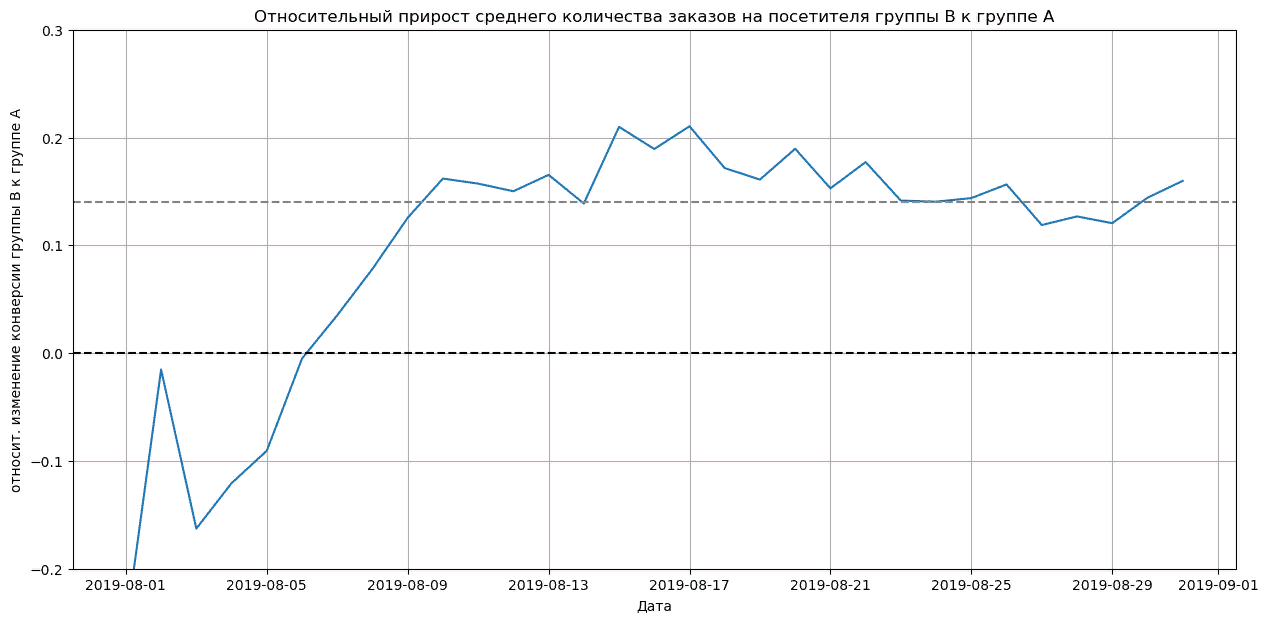
**по «очищенным» данным**
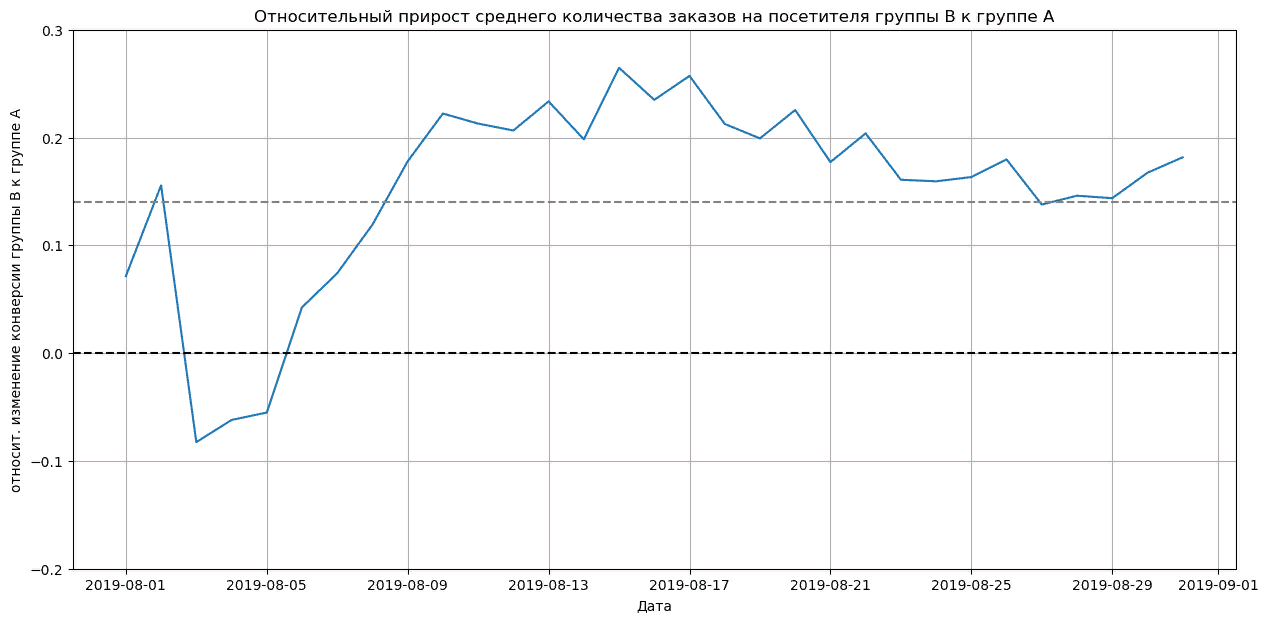

**- График различия среднего чека по «сырым» данным колеблется: это говорит об аномалиях в данных (сверхкрупные покупки в группе В). Сделать из этого графика определённые выводы нельзя.**

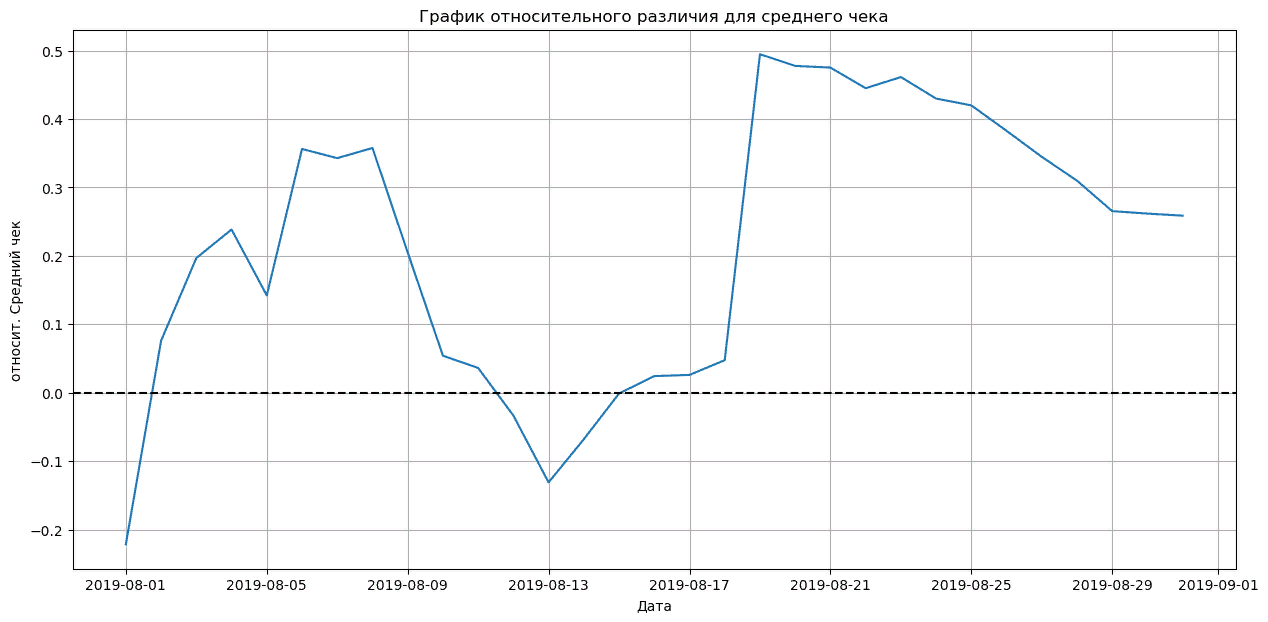

**График различия среднего чека по «очищенным» данным также колеблется и еще не зафиксировался. Сделать из этого графика определённые выводы нельзя.**

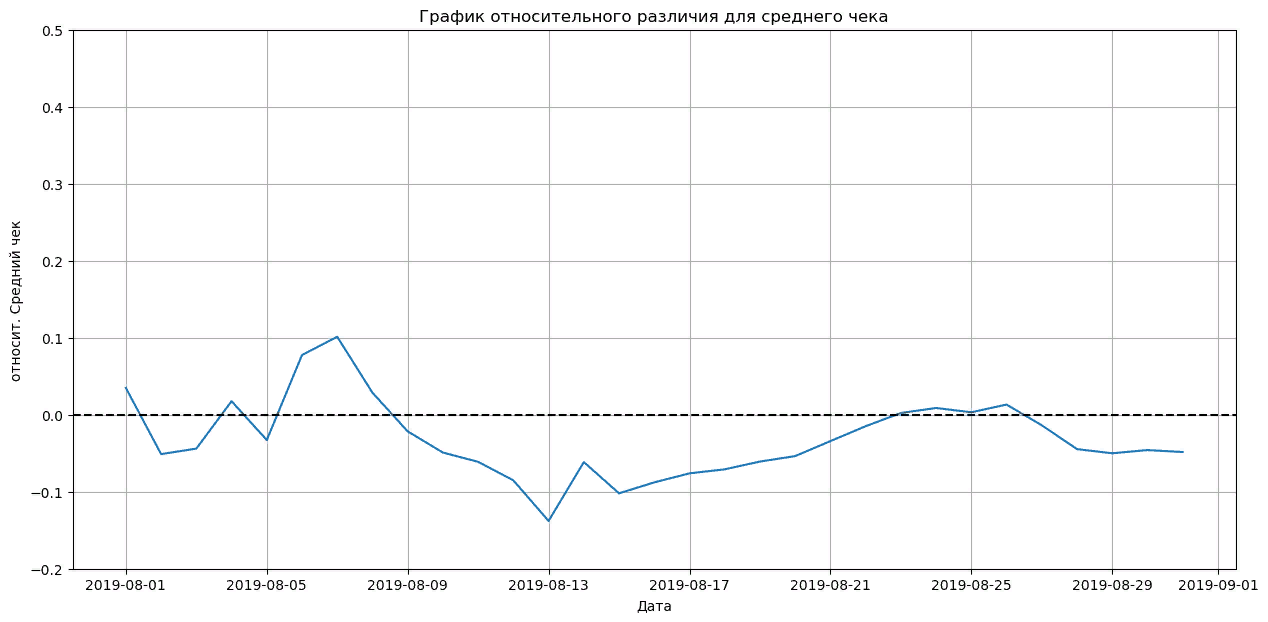

**Исходя из обнаруженных фактов, мы видим, что группы равны по среднему чеку, но группа B лучше группы A по конверсии. Принимаем решение остановить тест и признать его успешным, т.е. экспериментальная группа В статистически значимо лучше контрольной группы A.**